In [ ]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Distribution of labels

In [ ]:
import pandas as pd

train_data = pd.read_csv('train_cm.csv')

# Print the count of each label in the training data
label_counts = train_data['stance'].value_counts()
print(label_counts)


favour     316
against    247
neutral    236
Name: stance, dtype: int64


##sentence embedding 

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('train_cm.csv')

# Pre-trained sentence embedding model
model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')

# Extract sentence embeddings for the Telugu tweets
embeddings = model.encode(df['Comments'].tolist())

def extract_keywords(texts):
    vectorizer = TfidfVectorizer(max_features=25)
    vectorizer.fit(texts)
    tfidf_scores = vectorizer.transform(texts)
    tfidf_scores_array = tfidf_scores.toarray()
    documents = []
    for row in tfidf_scores_array:
        document = ' '.join([str(score) for score in row])
        documents.append(document)
    return documents

keywords = extract_keywords(df['Comments'].tolist())

features = []
for i in range(len(embeddings)):
    feature = list(embeddings[i]) + list(keywords[i])
    features.append(feature)

le = LabelEncoder()
df['stance_label'] = le.fit_transform(df['stance'])

df['sentence_embedding'] = df['Comments'].apply(lambda x: model.encode(x))

vectorizer = TfidfVectorizer()
X_keywords = vectorizer.fit_transform(df['Comments'])

# Combine the sentence embeddings and keyword features to create a final feature vector for each tweet
X_sentence = pd.DataFrame(df['sentence_embedding'].tolist())
X = pd.concat([X_sentence, pd.DataFrame(X_keywords.toarray())], axis=1)

##Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['stance_label'], test_size=0.2, random_state=42)


base_clf = DecisionTreeClassifier()

# Define the bagging classifier
bg = BaggingClassifier(estimator=base_clf, n_estimators=10)


bg.fit(X_train, y_train)

y_pred = bg.predict(X_test)

acc1 = accuracy_score(y_test, y_pred)
precision1, recall1, f1_score1, support1 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc1)
print('Precision:', precision1)
print('Recall:', recall1)
print('F1-Score:', f1_score1)
print('Support:', support1)


Accuracy: 0.71875
Precision: [0.85106383 0.6969697  0.61702128]
Recall: [0.8        0.76666667 0.58      ]
F1-Score: [0.82474227 0.73015873 0.59793814]
Support: [50 60 50]


##AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, df['stance_label'], test_size=0.2, random_state=42)


param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0]}


ab = AdaBoostClassifier()


grid_search = GridSearchCV(ab, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

acc2 = accuracy_score(y_test, y_pred)
precision2, recall2, f1_score2, support2 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc2)
print('Precision:', precision2)
print('Recall:', recall2)
print('F1-Score:', f1_score2)
print('Support:', support2)


Accuracy: 0.68125
Precision: [0.95       0.56382979 0.69230769]
Recall: [0.76       0.88333333 0.36      ]
F1-Score: [0.84444444 0.68831169 0.47368421]
Support: [50 60 50]


##GradientBoost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['stance_label'], test_size=0.2, random_state=42)

gb = GradientBoostingClassifier(n_estimators=60, learning_rate=1.0, max_depth=1, random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)

acc3 = accuracy_score(y_test, y_pred)
precision3, recall3, f1_score3, support3 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc3)
print('Precision:', precision3)
print('Recall:', recall3)
print('F1-Score:', f1_score3)
print('Support:', support3)


Accuracy: 0.71875
Precision: [0.97560976 0.63157895 0.62790698]
Recall: [0.8  0.8  0.54]
F1-Score: [0.87912088 0.70588235 0.58064516]
Support: [50 60 50]


##Confusion Matrix

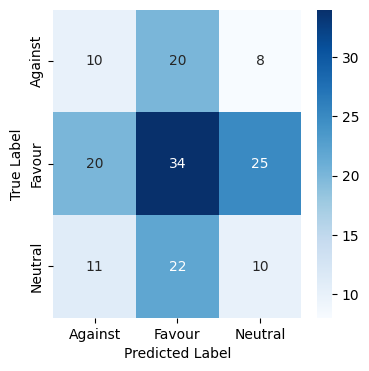

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df['stance_label'][639:800], y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Against', 'Favour', 'Neutral'], yticklabels=['Against', 'Favour', 'Neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



##MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, df['stance_label'], test_size=0.2, random_state=42)

# Train a Multilayer Perceptron model on the training set
clf = MLPClassifier(hidden_layer_sizes=(200, 150), activation='relu', solver='adam', max_iter=5000, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

acc4 = accuracy_score(y_test, y_pred)
precision4, recall4, f1_score4, support4 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc4)
print('Precision:', precision4)
print('Recall:', recall4)
print('F1-Score:', f1_score4)
print('Support:', support4)


Accuracy: 0.71875
Precision: [0.97619048 0.671875   0.57407407]
Recall: [0.82       0.71666667 0.62      ]
F1-Score: [0.89130435 0.69354839 0.59615385]
Support: [50 60 50]


##RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['stance_label'], test_size=0.2, random_state=42)

# Train a Random Forest model on the training set
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc6 = accuracy_score(y_test, y_pred)
precision6, recall6, f1_score6, support6 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc6)
print('Precision:', precision6)
print('Recall:', recall6)
print('F1-Score:', f1_score6)
print('Support:', support6)

Accuracy: 0.73125
Precision: [1.         0.61728395 0.70731707]
Recall: [0.76       0.83333333 0.58      ]
F1-Score: [0.86363636 0.70921986 0.63736264]
Support: [50 60 50]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df['stance_label'][639:800], y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Against', 'Favour', 'Neutral'], yticklabels=['Against', 'Favour', 'Neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##Naive Bayes

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the data
df = pd.read_csv('train_cm.csv')

# Extract the features and target variable
X = df['Comments']
y = df['stance']

vectorizer = TfidfVectorizer(sublinear_tf=True)

X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

acc5 = accuracy_score(y_test, y_pred)
precision5, recall5, f1_score5, support5 = precision_recall_fscore_support(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy:', acc5)
print('Precision:', precision5)
print('Recall:', recall5)
print('F1-Score:', f1_score5)
print('Support:', support5)

Accuracy: 0.6875
Precision: [0.90909091 0.57471264 0.68965517]
Recall: [0.8        0.83333333 0.4       ]
F1-Score: [0.85106383 0.68027211 0.50632911]
Support: [50 60 50]


In [ ]:
print("Accuracy of Bagging Classifier",acc1,acc2,acc3,acc4,acc5,acc6)
print("Accuracy of Gradient Boosting Classifierr",acc3)
print("Accuracy of AdaBoost Classifier",acc2)
print("Accuracy of Multi-layer Perceptron Classifier",acc4)
print("Accuracy of Gaussian Naive Bayes Classifier",acc5)
print("Accuracy of Random Forest Classifier",acc6)

Accuracy of Bagging Classifier 0.71875 0.68125 0.71875 0.71875 0.6875 0.73125
Accuracy of Gradient Boosting Classifierr 0.71875
Accuracy of AdaBoost Classifier 0.68125
Accuracy of Multi-layer Perceptron Classifier 0.71875
Accuracy of Gaussian Naive Bayes Classifier 0.6875
Accuracy of Random Forest Classifier 0.73125


In [ ]:
print("Precision of Bagging Classifier",precision1)
print("Precision of Gradient Boosting Classifierr",precision3)
print("Precision of AdaBoost Classifier",precision2)
print("Precision of Multi-layer Perceptron Classifier",precision4)
print("Precision of Gaussian Naive Bayes Classifier",precision5)
print("Precision of Random Forest Classifier",precision6)

Precision of Bagging Classifier [0.85106383 0.6969697  0.61702128]
Precision of Gradient Boosting Classifierr [0.97560976 0.63157895 0.62790698]
Precision of AdaBoost Classifier [0.95       0.56382979 0.69230769]
Precision of Multi-layer Perceptron Classifier [0.97619048 0.671875   0.57407407]
Precision of Gaussian Naive Bayes Classifier [0.90909091 0.57471264 0.68965517]
Precision of Random Forest Classifier [1.         0.61728395 0.70731707]


In [ ]:
print("Recall of Bagging Classifier",recall1)
print("Recall of Gradient Boosting Classifierr",recall3)
print("Recall of AdaBoost Classifier",precision2)
print("Recall of Multi-layer Perceptron Classifier",recall4)
print("Recall of Gaussian Naive Bayes Classifier",recall5)
print("Recall of Random Forest Classifier",recall6)

Recall of Bagging Classifier [0.8        0.76666667 0.58      ]
Recall of Gradient Boosting Classifierr [0.8  0.8  0.54]
Recall of AdaBoost Classifier [0.95       0.56382979 0.69230769]
Recall of Multi-layer Perceptron Classifier [0.82       0.71666667 0.62      ]
Recall of Gaussian Naive Bayes Classifier [0.8        0.83333333 0.4       ]
Recall of Random Forest Classifier [0.76       0.83333333 0.58      ]


In [ ]:
print("F1-Score of Bagging Classifier",f1_score1)
print("F1-Score of Gradient Boosting Classifierr",f1_score3)
print("F1-Score of AdaBoost Classifier",f1_score2)
print("F1-Score of Multi-layer Perceptron Classifier",f1_score4)
print("F1-Score of Gaussian Naive Bayes Classifier",f1_score5)
print("F1-Score of Random Forest Classifier",f1_score6)

F1-Score of Bagging Classifier [0.82474227 0.73015873 0.59793814]
F1-Score of Gradient Boosting Classifierr [0.87912088 0.70588235 0.58064516]
F1-Score of AdaBoost Classifier [0.84444444 0.68831169 0.47368421]
F1-Score of Multi-layer Perceptron Classifier [0.89130435 0.69354839 0.59615385]
F1-Score of Gaussian Naive Bayes Classifier [0.85106383 0.68027211 0.50632911]
F1-Score of Random Forest Classifier [0.86363636 0.70921986 0.63736264]


In [ ]:
print("Support of Bagging Classifier",support1)
print("Support of Gradient Boosting Classifierr",support3)
print("Support of AdaBoost Classifier",support2)
print("Support of Multi-layer Perceptron Classifier",support4)
print("Support of Gaussian Naive Bayes Classifier",support5)
print("Support of Random Forest Classifier",support6)

Support of Bagging Classifier [50 60 50]
Support of Gradient Boosting Classifierr [50 60 50]
Support of AdaBoost Classifier [50 60 50]
Support of Multi-layer Perceptron Classifier [50 60 50]
Support of Gaussian Naive Bayes Classifier [50 60 50]
Support of Random Forest Classifier [50 60 50]


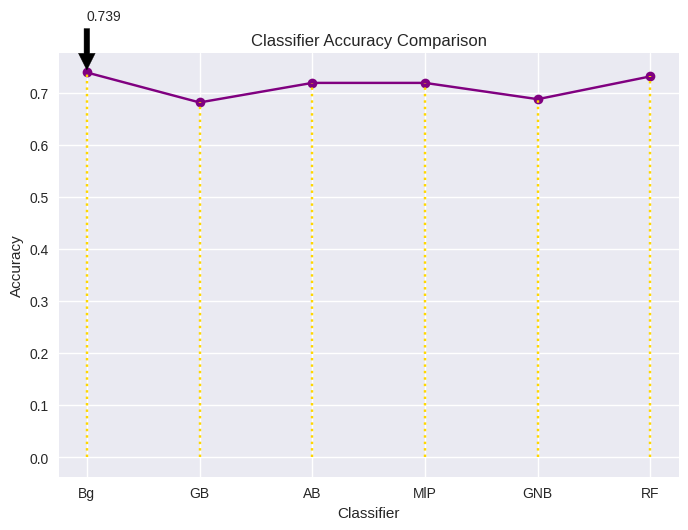

In [ ]:
import matplotlib.pyplot as plt

# Create lists of accuracies
classifiers = ['Bg', 'GB', 'AB', 'MlP', 'GNB', 'RF']
accuracies = [0.73875, 0.68125, 0.71875, 0.71875, 0.6875, 0.73125]

max_index = accuracies.index(max(accuracies))

plt.plot(classifiers, accuracies, marker='o', color='purple')

for i in range(len(classifiers)):
    plt.plot([classifiers[i], classifiers[i]], [0, accuracies[i]], linestyle=':', color='gold')
    
plt.annotate(str(round(accuracies[max_index], 3)), xy=(classifiers[max_index], accuracies[max_index]), xytext=(classifiers[max_index], accuracies[max_index] + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Classifier Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

# Show the plot
plt.show()


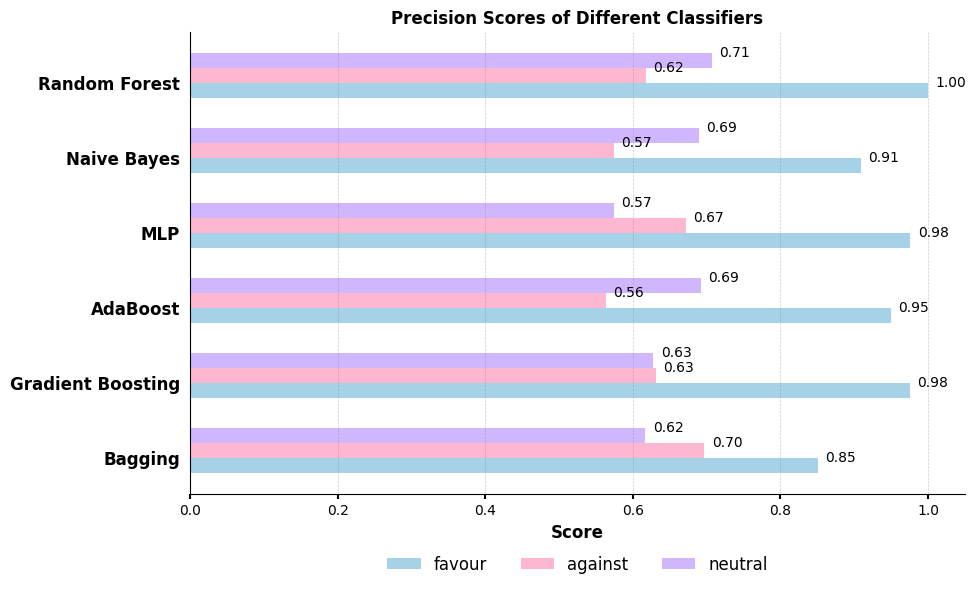

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
precision = [[0.85106383, 0.6969697  ,0.61702128]
, [0.97560976 ,0.63157895, 0.62790698]
,[0.95,0.56382979 ,0.69230769]
, [0.97619048 ,0.671875  , 0.57407407]
, [0.90909091 ,0.57471264, 0.68965517]
,[1.,0.61728395 ,0.70731707]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2

for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [p[i] for p in precision], height=bar_width, color=colors[i], alpha=0.8, label=metric)

ax.set_title('Precision Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


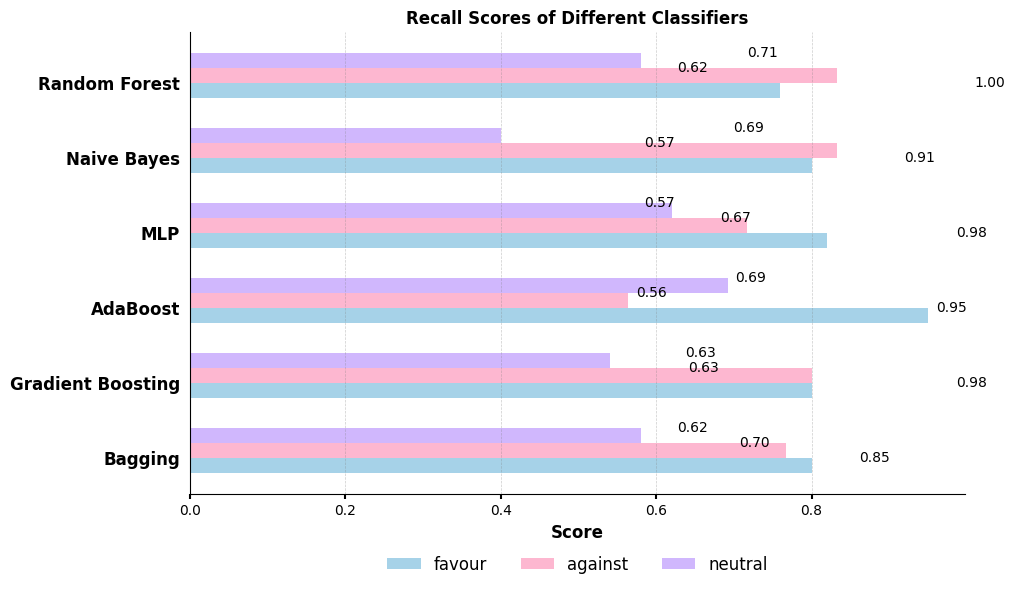

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
recall =[[0.8   ,  0.76666667 ,0.58      ]
, [0.8  ,0.8,  0.54]
,[0.95  ,  0.56382979, 0.69230769]
,[0.82 , 0.71666667 ,0.62      ]
,[0.8   , 0.83333333, 0.4       ]
,[0.76  , 0.83333333, 0.58      ]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2

# Create horizontal bars for each metric
for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [r[i] for r in recall], height=bar_width, color=colors[i], alpha=0.8, label=metric)

# Set plot properties
ax.set_title('Recall Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)


# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


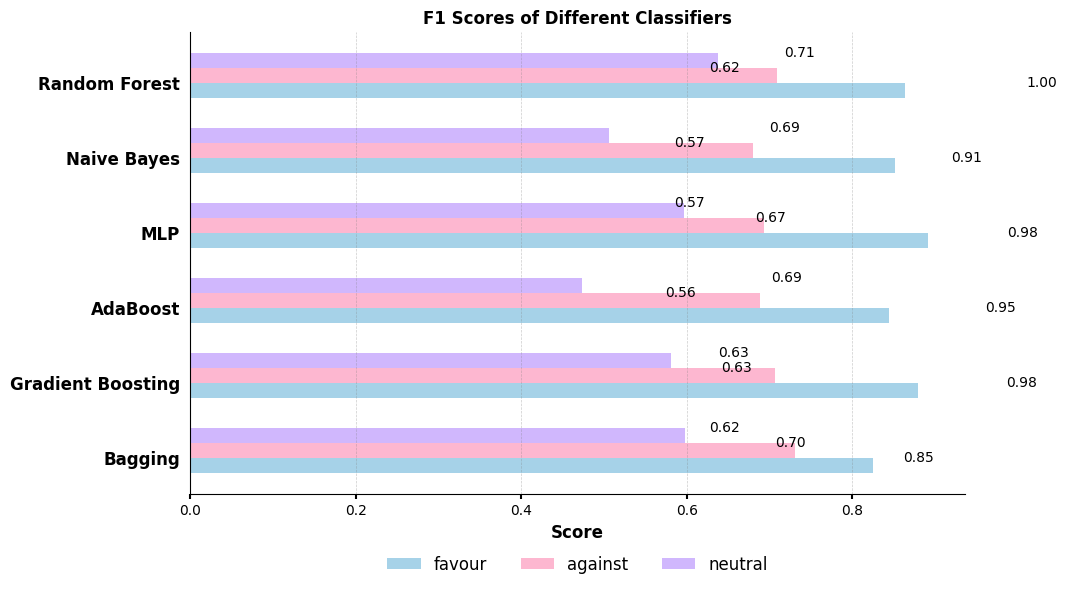

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']
f1_score =[ [0.82474227, 0.73015873 ,0.59793814]
,[0.87912088 ,0.70588235 ,0.58064516]
, [0.84444444 ,0.68831169 ,0.47368421]
,[0.89130435, 0.69354839 ,0.59615385]
, [0.85106383 ,0.68027211 ,0.50632911]
,[0.86363636, 0.70921986 ,0.63736264]]
colors = ['#90c7e3', '#fda5c5', '#c5a5fd']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.2

# Create horizontal bars for each metric
for i, metric in enumerate(['favour', 'against', 'neutral']):
    ax.barh(np.arange(len(classifiers)) + i*bar_width, [f[i] for f in f1_score], height=bar_width, color=colors[i], alpha=0.8, label=metric)

# Set plot properties
ax.set_title('F1 Scores of Different Classifiers', fontweight='bold')
ax.set_yticks(np.arange(len(classifiers)) + bar_width/2)
ax.set_yticklabels(classifiers, fontweight='bold', fontsize=12)
ax.set_xlabel('Score', fontweight='bold', fontsize=12)
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=0)
ax.xaxis.grid(color='gray', linewidth=0.5, linestyle='dashed', alpha=0.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False, fontsize=12)


# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to bars
for i, classifier in enumerate(classifiers):
    for j, metric in enumerate(['favour', 'against', 'neutral']):
        value = precision[i][j]
        ax.text(value+0.01, i+j*bar_width+bar_width/2, f'{value:.2f}', va='center', fontsize=10)

# Show plot
plt.show()


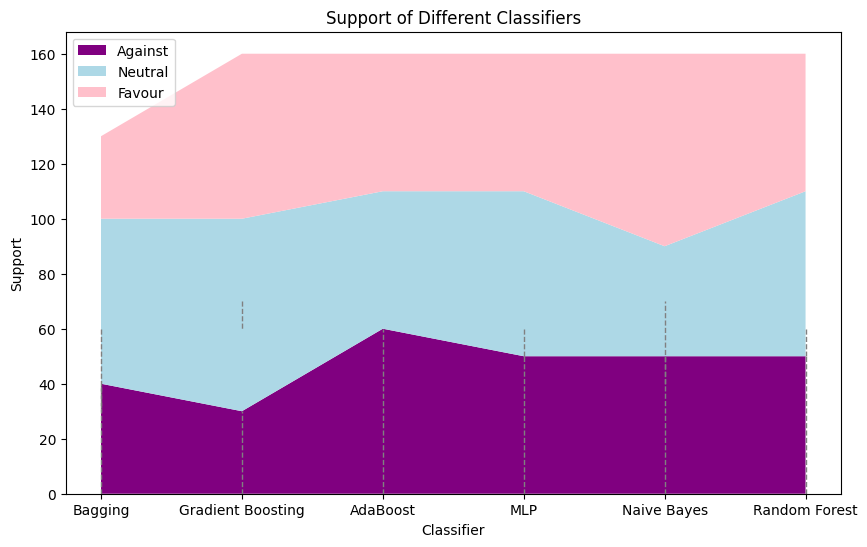

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
classifiers = ['Bagging', 'Gradient Boosting', 'AdaBoost', 'MLP', 'Naive Bayes', 'Random Forest']

stance = ['Against', 'Neutral', 'Favour']
support = np.array([[40 ,60, 30]
,[30, 70 ,60]
,[60 ,50 ,50]
,[50, 60, 50]
,[50 ,40, 70]
, [50 ,60 ,50]])

# Create stacked area chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked area chart
ax.stackplot(classifiers, support.T, labels=stance, colors=['purple', 'lightblue', 'pink'])

# Add borders and dotted lines from classifiers to support values
for i in range(len(classifiers)):
    for j in range(len(stance)):
        if j == 0:
            # Plot left border of stacked area chart
            ax.plot([classifiers[i], classifiers[i]], [0, support[i][j]], color='gray', linestyle='--', linewidth=1)
        elif j == len(stance) - 1:
            # Plot right border of stacked area chart
            ax.plot([classifiers[i], classifiers[i]], [support[i][j-1], support[i][j]], color='gray', linestyle='--', linewidth=1)
        else:
            # Plot dotted line for middle of stacked area chart
            y_start = support[i][j-1] + (support[i][j] - support[i][j-1]) / 2
            y_end = support[i][j] - (support[i][j] - support[i][j-1]) / 2
            ax.plot([classifiers[i], classifiers[i]], [y_start, y_end], color='gray', linestyle='--', linewidth=1)

# Set plot properties
ax.set_title('Support of Different Classifiers')
ax.set_xlabel('Classifier')
ax.set_ylabel('Support')
ax.legend(loc='upper left')

# Show plot
plt.show()
